## Import Library

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from binance.client import Client
from datetime import datetime

## Initialise API

In [27]:
API_KEY = 'JPFZLK0ZgvhSniD3fvCNDQSC8UFin0kLKeIOJToe9LyGaJhQG29ZVWqTuZ792jAV'
API_SECRET = 'jw1UUQ4r5xFUgZHSiZcS8hssAKqwDYr8QzehZiNTRnXZBRWvpNQ9mtRyGcS4vfja'

client = Client(API_KEY, API_SECRET)

## Initialise Wallet

In [28]:
class Wallet:
    def __init__(self, initial_balance):
        self.balance = initial_balance
        self.coins = {}

    def add_coin(self, name, quantity, value):
        cost = quantity * value
        # Check if have enough money
        if self.balance > cost:
            self.balance -= cost
            if name in self.coins:
                self.coins[name] += quantity
            else:
                self.coins[name] = quantity
            return True
        else:
            return False

    def remove_coin(self, name, quantity, value):
        if name in self.coins:
            if self.coins[name] >= quantity:
                cost = quantity * value
                self.balance += cost
                self.coins[name] -= quantity
                if self.coins[name] == 0:
                    del self.coins[name]
                return True
            else:
                return False
        else:
            return False

    def get_coin_quantity(self, name):
        if name in self.coins:
            return self.coins[name]
        else:
            return 0

    def get_balance(self):
        return self.balance
    
    def get_coins(self):
        return self.coins

## Strategy

In [29]:
class Strategy:
    def __init__(self, window_size):
        self.window_size = window_size
        self.price_history = []

    def update_price_history(self, price):
        self.price_history.append(price)
        if len(self.price_history) > self.window_size:
            self.price_history.pop(0)

    def generate_signals(self, observed_price):
        if len(self.price_history) < self.window_size:
            return 'HOLD'
        average_price = sum(self.price_history) / self.window_size
        if observed_price > average_price:
            return 'BUY'
        else:
            return 'SELL'

## Backtesting Strategy

### Parameters

In [30]:
symbol = 'BTCUSDT'
coin_name = 'BTC'

initial_balance = 100000
window_size = 50

In [31]:
interval = Client.KLINE_INTERVAL_1DAY  # Replace with the desired interval (e.g., KLINE_INTERVAL_1MINUTE, KLINE_INTERVAL_1HOUR)
start_time = int(datetime(2020,1,1,0,0).timestamp() * 1000) # Replace with the desired start time
end_time = int(datetime(2022,1,1,0,0).timestamp() * 1000)

### Fetch Data

In [32]:
klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start_time, end_str=end_time)
# Extract close prices and timestamps from kline data
close_prices = [float(kline[4]) for kline in klines]
timestamps = [datetime.fromtimestamp(kline[0] / 1000) for kline in klines]

# Create a DataFrame from the extracted data
data = pd.DataFrame({'Timestamp': timestamps, 'Close Price': close_prices})

### Initialise Objects

In [33]:
wallet = Wallet(initial_balance=initial_balance)
strategy = Strategy(window_size=window_size)

### Simulating

In [34]:
data_balance = [None for _ in close_prices]
data_signal = [None for _ in close_prices]

for row in data.itertuples():
    data_index = row[0]
    timestamp = row[1]
    close_price = row[2]

    strategy.update_price_history(close_price)
    signal = strategy.generate_signals(close_price)

    if signal == 'BUY':
        available_balance = wallet.get_balance()
        if available_balance > 1:
            quantity = available_balance / close_price
            if wallet.add_coin(coin_name, quantity, close_price):
                data_signal[data_index] = 'BUY'

    elif signal == 'SELL':
        coin_pair = wallet.get_coins()
        if len(coin_pair) > 0:
            for coin_name_in_wallet, coin_qty_in_wallet in coin_pair.items():
                if coin_name == coin_name_in_wallet:
                    if wallet.remove_coin(coin_name, coin_qty_in_wallet, close_price):
                        data_signal[data_index] = 'SELL'
                    break
    
    data_balance[data_index] = wallet.get_balance()

## Results

### Graph

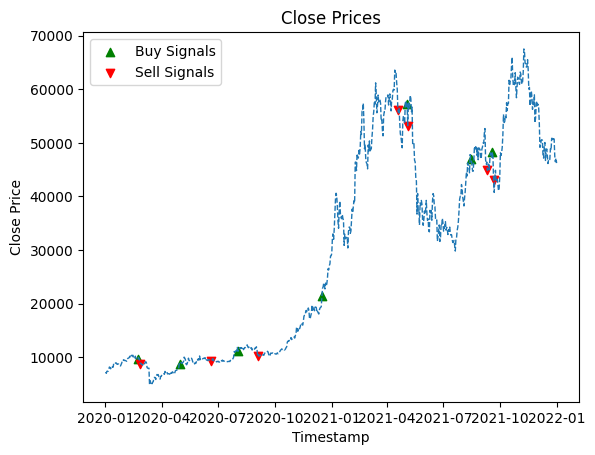

In [37]:
data['Signal'] = data_signal
data['Balance'] = data_balance

# Plot the close prices
plt.plot(data['Timestamp'], data['Close Price'],
         linestyle='--', linewidth=1)
plt.title('Close Prices')
plt.xlabel('Timestamp')
plt.ylabel('Close Price')

plt.scatter(data.loc[data['Signal'] == 'BUY', 'Timestamp'].values,
            data.loc[data['Signal'] == 'BUY', 'Close Price'].values,
            marker='^',
            color='green',
            label='Buy Signals')

plt.scatter(data.loc[data['Signal'] == 'SELL', 'Timestamp'].values,
            data.loc[data['Signal'] == 'SELL', 'Close Price'].values,
            marker='v',
            color='red',
            label='Sell Signals')

plt.legend()
plt.show()